In [1]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
model_paths = ["Save_File/seperate_model_best_05_28/A/checkpoints/epoch=39-step=1199.ckpt",
                "Save_File/seperate_model_best_05_28/B/checkpoints/epoch=57-step=1739.ckpt",
                "Save_File/seperate_model_best_05_28/C/checkpoints/epoch=41-step=1259.ckpt",
                "Save_File/seperate_model_best_05_28/D/checkpoints/epoch=44-step=1349.ckpt",
                "Save_File/seperate_model_best_05_28/E/checkpoints/epoch=40-step=1229.ckpt"]

In [3]:
data_path = "./data/train.csv"

group = [
    [34, 40, 42, 41, 4, 10, 11, 12],
    [35, 6, 48, 27, 57, 8, 25, 56, 26, 55, 47, 13, 53, 18, 7, 17, 46],
    [31, 33, 9, 3, 1, 32],
    [29, 38, 43, 58, 15, 22, 39, 54, 23, 44, 45, 37, 52, 2, 14],
    [21, 19, 50, 49, 20, 51, 30, 36, 28, 59, 5, 60, 16, 24]
]

data = pd.read_csv(data_path, parse_dates = ["date_time"])

data["time_idx"] = 0
data["month"] = 0
data["energy_group"] = 0
data["Week"] = 0
data["24Hour"] = 0

data.loc[data["num"].isin(group[0]), "energy_group"] = str(1)
data.loc[data["num"].isin(group[1]), "energy_group"] = str(2)
data.loc[data["num"].isin(group[2]), "energy_group"] = str(3)
data.loc[data["num"].isin(group[3]), "energy_group"] = str(4)
data.loc[data["num"].isin(group[4]), "energy_group"] = str(5)

data.loc[data["date_time"].dt.month == 6, 'month'] = 0
data.loc[data["date_time"].dt.month == 7, 'month'] = 30
data.loc[data["date_time"].dt.month == 8, 'month'] = 61

data["time_idx"] = data["date_time"].dt.hour + data["date_time"].dt.day * (24) + data["month"] * 24
data["time_idx"] = data["time_idx"] - min(data["time_idx"])

data["Week"] = (data["date_time"].dt.day + data["month"]) % 7
data["24Hour"] = data["date_time"].dt.hour

data = data.drop("month",axis='columns')

data.rename(columns = {'전력사용량(kWh)' : 'kWH', '기온(°C)' : 'C', '풍속(m/s)' : 'm/s', '습도(%)' : 'wet', '강수량(mm)' : 'mm','일조(hr)' : 'hr', '비전기냉방설비운영' : "non_electric_aircondition", "태양광보유" : "sunlight"}, inplace = True)

data = data.astype({'non_electric_aircondition' : int, 'sunlight' : int})
data['num'] = data['num'].apply(str)
data['Week'] = data['Week'].apply(str)
data['24Hour'] = data['24Hour'].apply(str)

data_bag = [
    data.loc[data["energy_group"] == "1"].copy(),
    data.loc[data["energy_group"] == "2"].copy(),
    data.loc[data["energy_group"] == "3"].copy(),
    data.loc[data["energy_group"] == "4"].copy(),
    data.loc[data["energy_group"] == "5"].copy()
]

C:\Users\Eunchan\anaconda3\envs\torch1\lib\site-packages\pytorch_forecasting\models\base_model.py:663: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


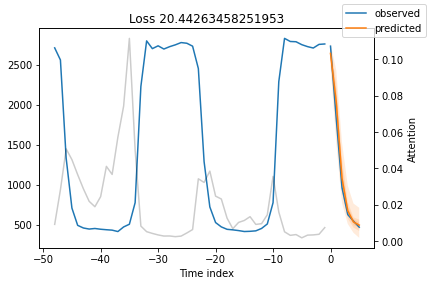

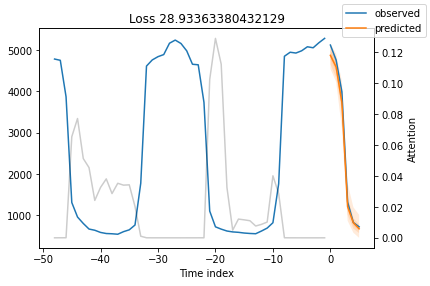

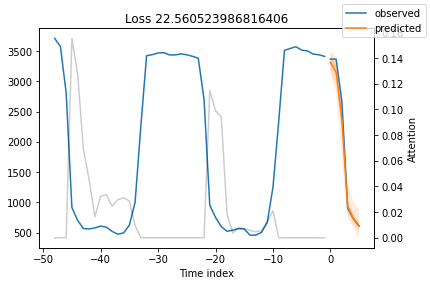

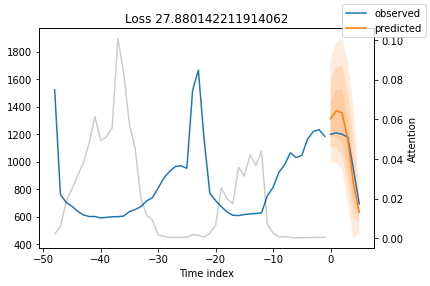

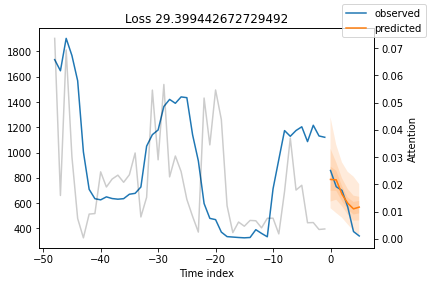

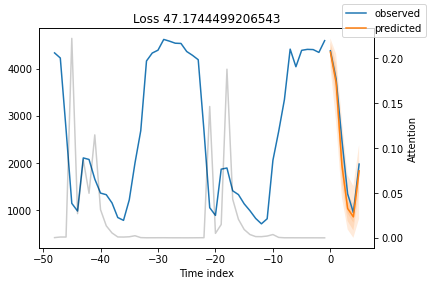

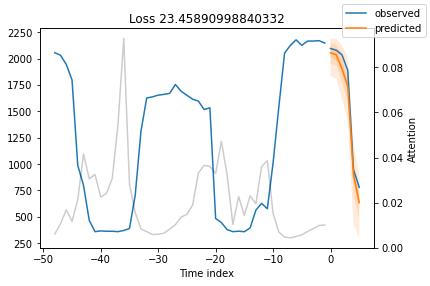

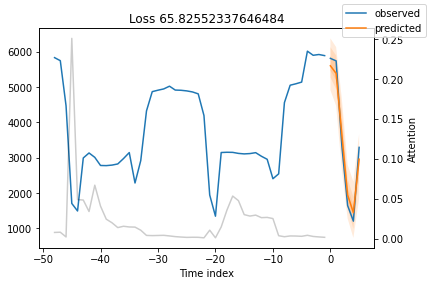

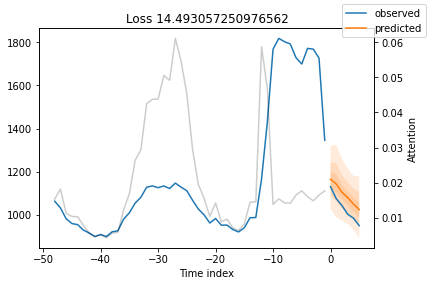

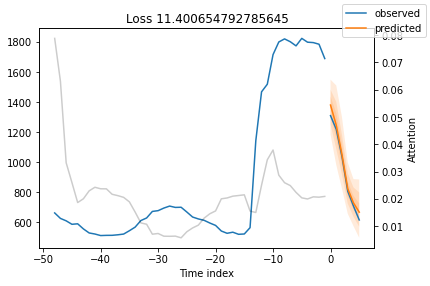

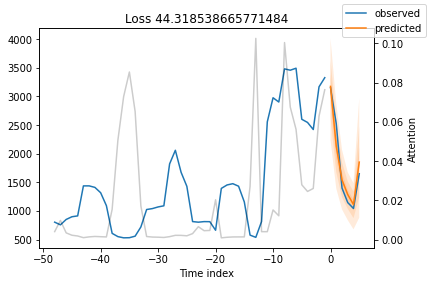

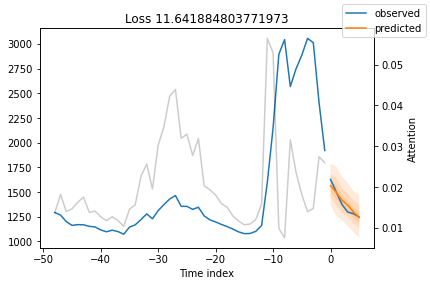

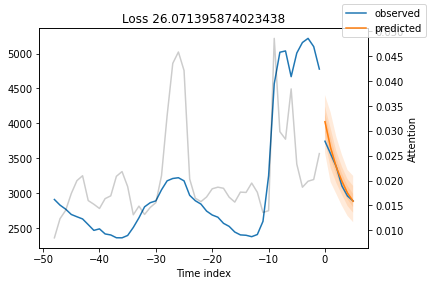

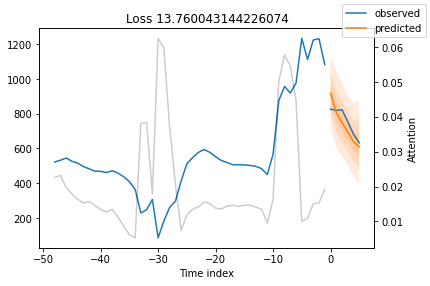

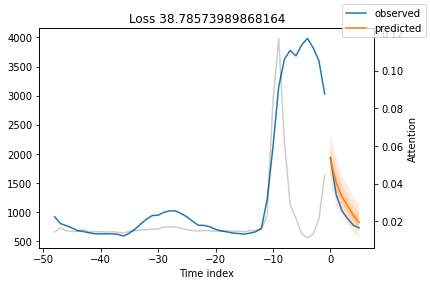

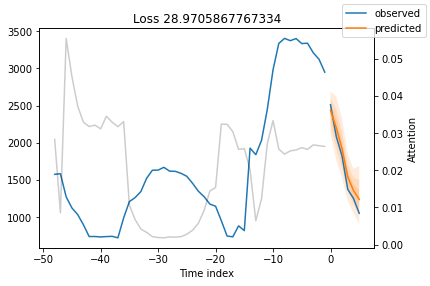

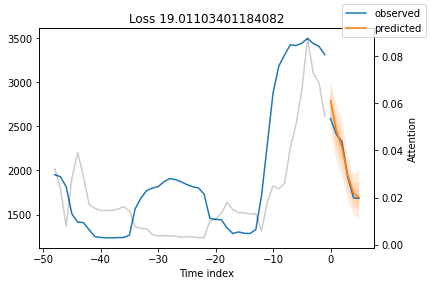

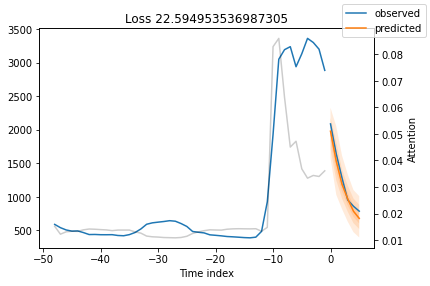

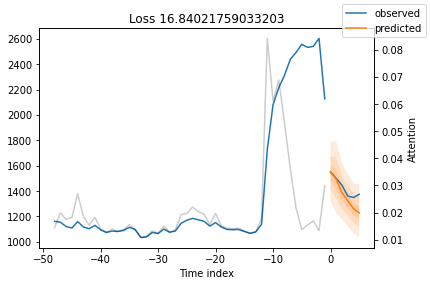

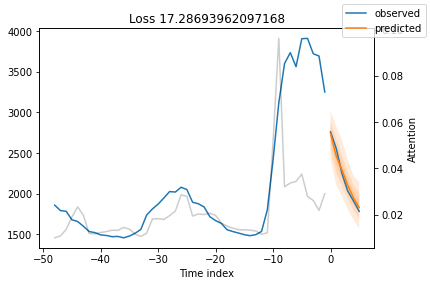

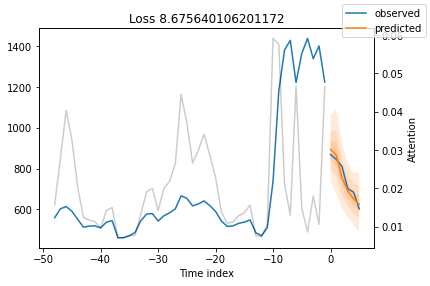

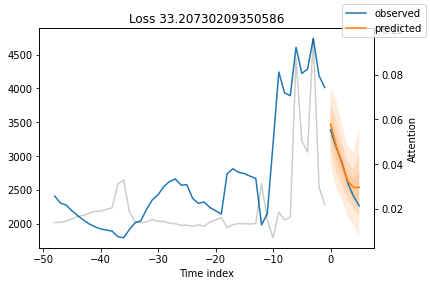

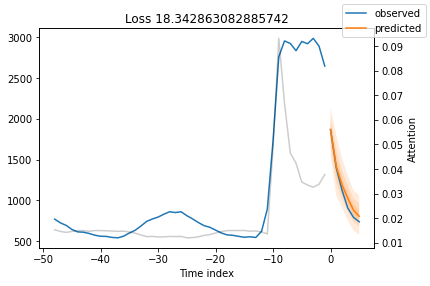

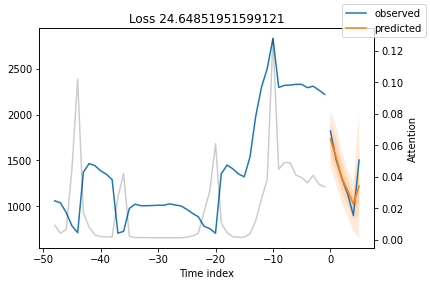

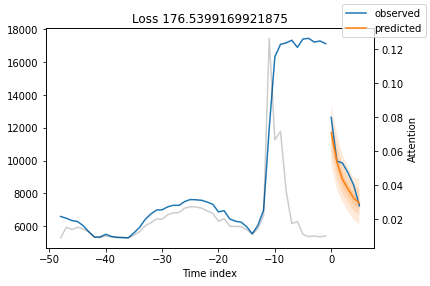

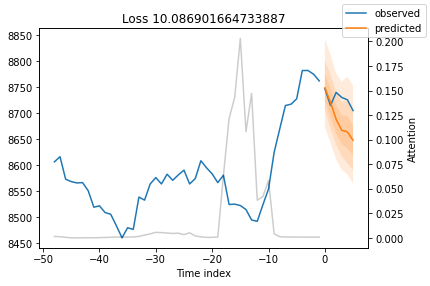

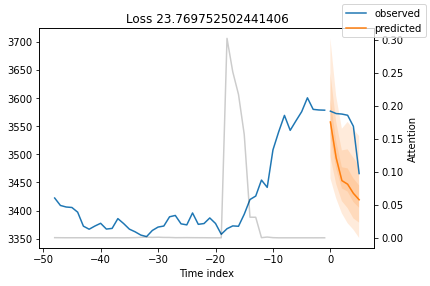

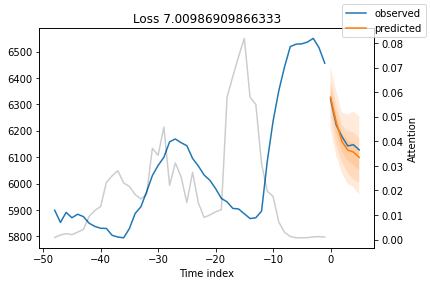

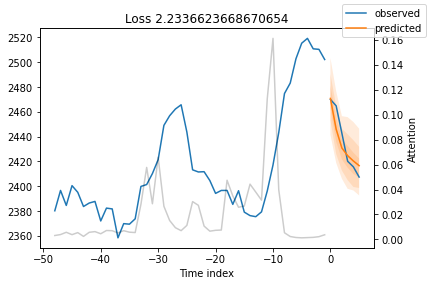

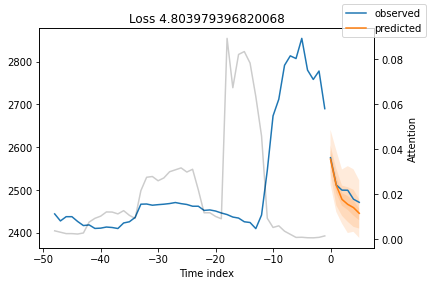

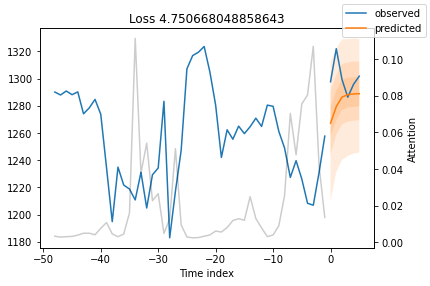

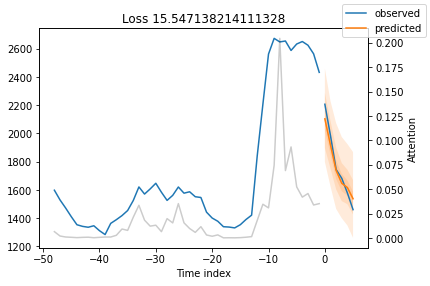

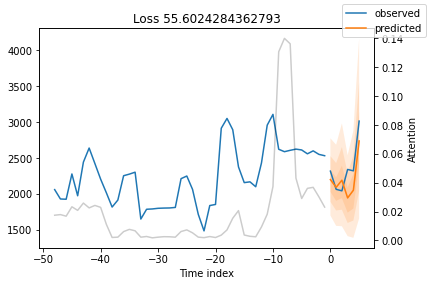

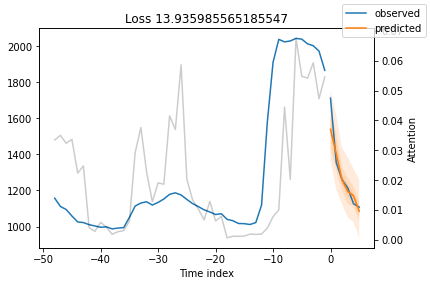

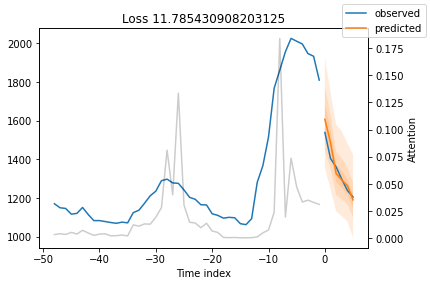

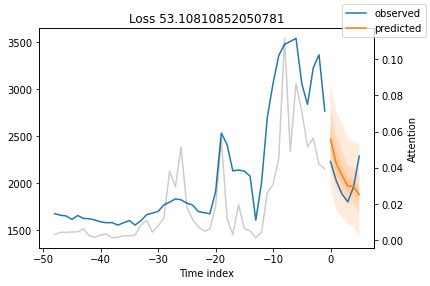

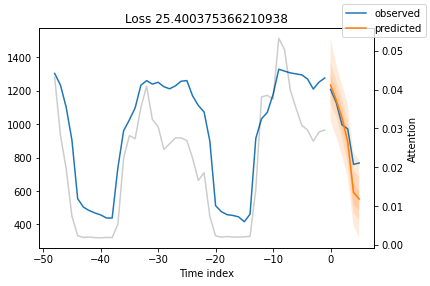

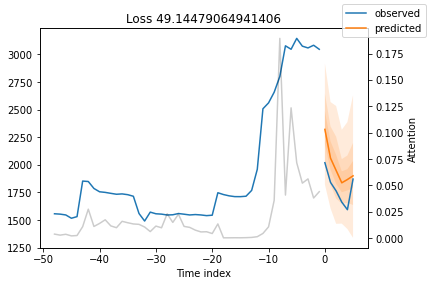

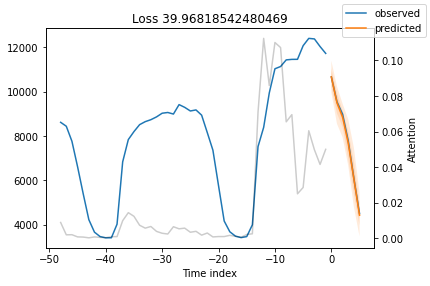

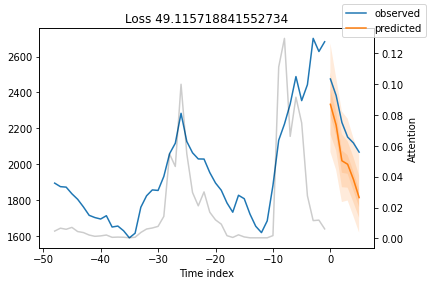

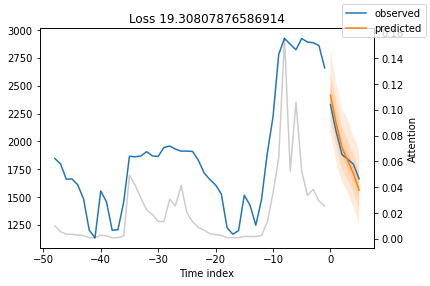

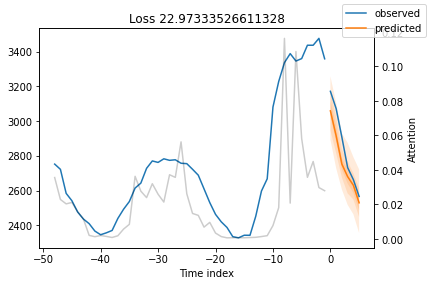

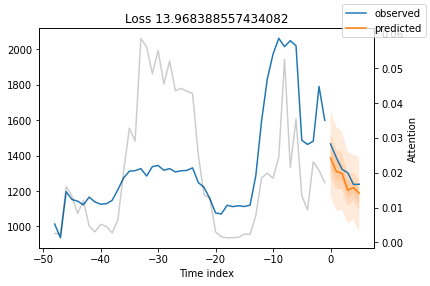

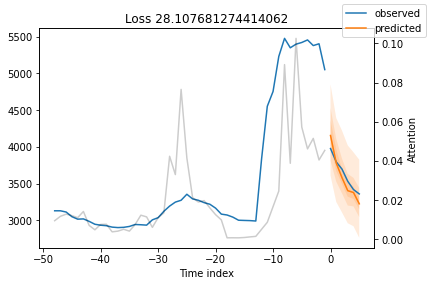

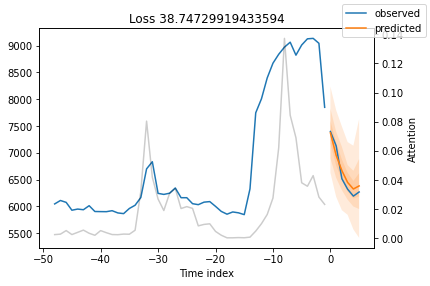

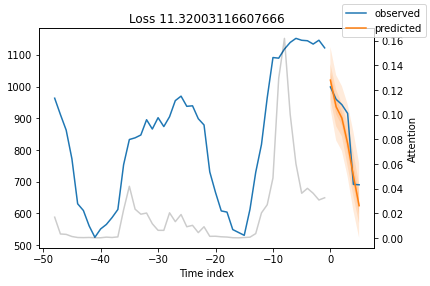

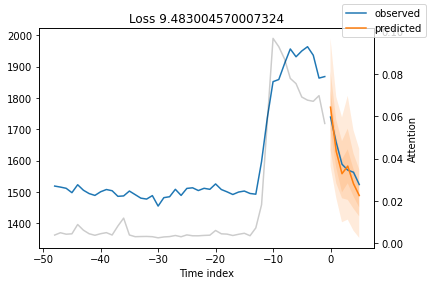

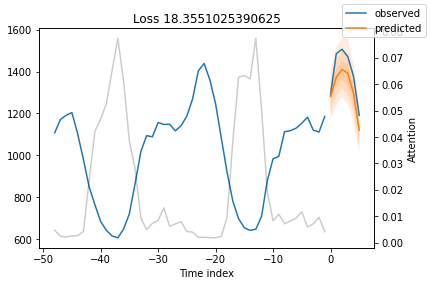

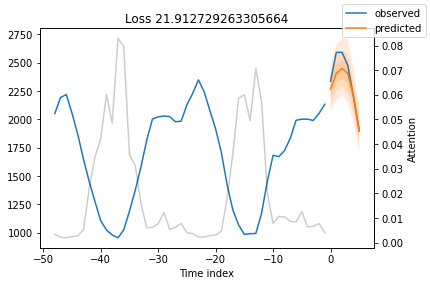

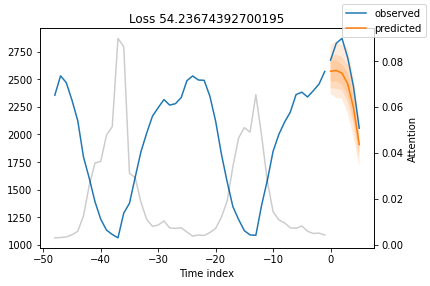

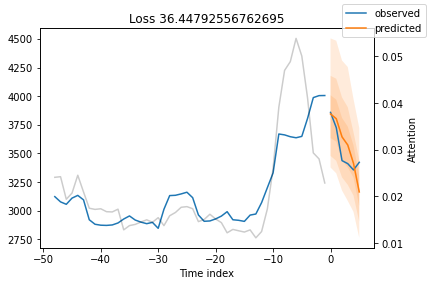

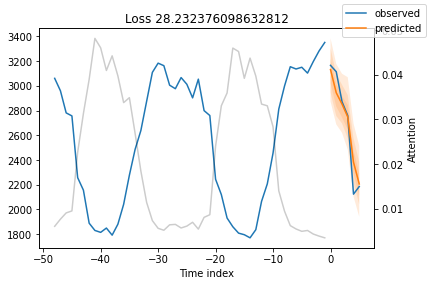

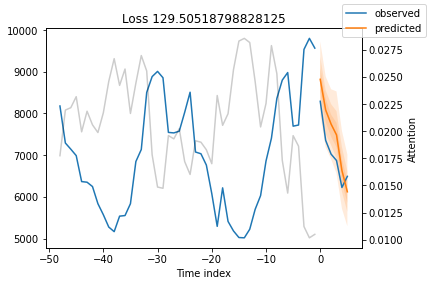

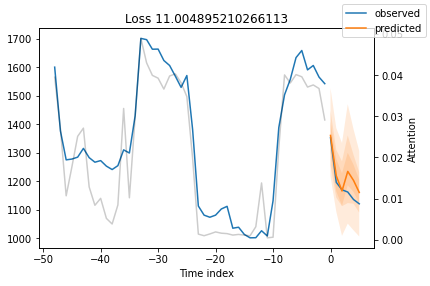

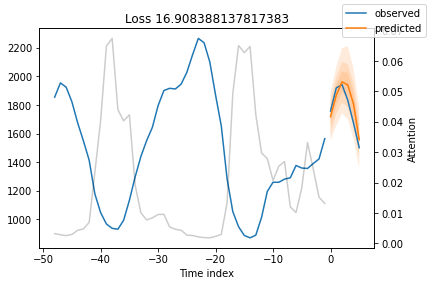

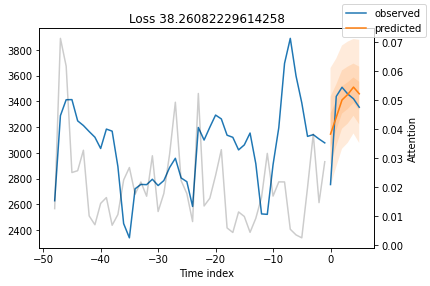

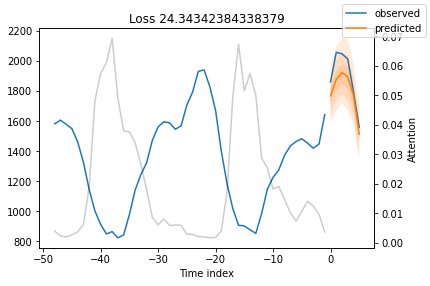

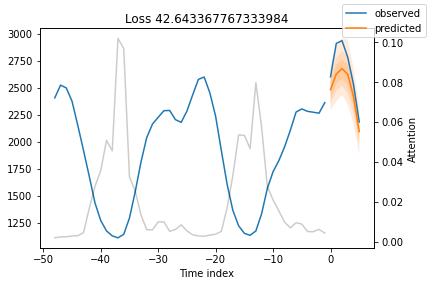

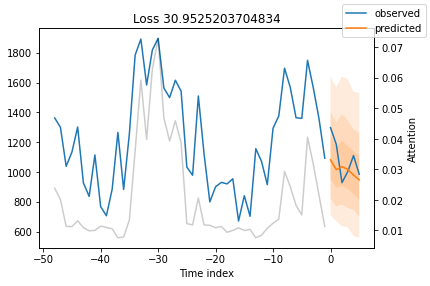

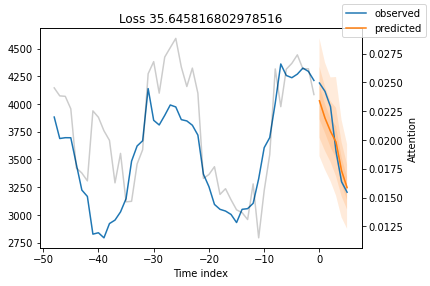

In [4]:
for i in range(len(model_paths)):
    model_path = model_paths[i]
    data = data_bag[i]

    max_prediction_length = 6
    max_encoder_length = 48
    training_cutoff = data["time_idx"].max() - max_prediction_length

    training = TimeSeriesDataSet(
        data[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="kWH",
        group_ids=["num"],
        min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
        max_encoder_length=max_encoder_length,
        min_prediction_length=3,
        max_prediction_length=max_prediction_length,
        static_categoricals=["num", "energy_group"],
        static_reals=["non_electric_aircondition", "sunlight"],
        time_varying_known_categoricals=["Week", "24Hour"],
        time_varying_known_reals=["C", "m/s", "wet", "mm", "hr", "time_idx"],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=["kWH"],
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )

    # create validation set (predict=True) which means to predict the last max_prediction_length points in time
    # for each series
    validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

    # create dataloaders for model
    batch_size = 32  # set this between 32 to 128
    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

    best_tft = TemporalFusionTransformer.load_from_checkpoint(model_path)

    raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

    for idx in range(len(group[i])):
        best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)
    